<a href="https://colab.research.google.com/github/beamcodeup/nyt-solver/blob/main/CS221_Project_NYT_Connections.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Documentations
https://radimrehurek.com/gensim/auto_examples/howtos/run_downloader_api.html#sphx-glr-auto-examples-howtos-run-downloader-api-py

https://radimrehurek.com/gensim/models/word2vec.html#pretrained-models

https://github.com/piskvorky/gensim-data?tab=readme-ov-file

https://medium.com/@manansuri/a-dummys-guide-to-word2vec-456444f3c673

https://radimrehurek.com/gensim_3.8.3/models/keyedvectors.html

https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

# Import Libraries

In [14]:
# Useful Libraries
import os
import json
import importlib

def check_package(package_name):
    try:
        importlib.import_module(package_name)
        print(f"{package_name} is already installed.")
    except ImportError:
        print(f"{package_name} is not installed.")
        if package_name == "sklearn":
          !pip install --upgrade scikit-learn
        elif package_name == "google-cloud-storage":
          !pip install --upgrade google-cloud-storage
        else:
          !pip install --upgrade {package_name}

!python --version
packages = ["numpy","pandas","gensim","sklearn","psutil","spacy","google.cloud"]
for package in packages:
  check_package(package)

# Third-Party Libraries
import numpy as np
import pandas as pd
import gensim
import gensim.downloader as api
from gensim.models import Word2Vec
import spacy
import google.cloud.storage as gcs
from gensim.models import KeyedVectors
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from collections import Counter
import seaborn as sns
# !pip install --upgrade gensim
# !pip install --upgrade scikit-learn
# !pip install --upgrade psutil
# !pip install --upgrade spacy

Python 3.10.12
numpy is already installed.
pandas is already installed.
gensim is already installed.
sklearn is already installed.
psutil is already installed.
spacy is already installed.
google.cloud is already installed.


## Fetch game file and word2vec models

In [15]:
# Download a pre-trained model from https://github.com/piskvorky/gensim-data.
# Model data: Google News (about 100 billion words)
# Model name: "word2vec-google-news-300"
# Metadata: 1662 MB, 3000000 vectors
# This takes up to 1-2 min to download and load.
#word2VecModel = api.load("glove-twitter-25")

modelNames = ["word2vec-google-news-300", "glove-wiki-gigaword-50"]
modelName = modelNames[1]     # Jack: I temporarily switches this to a much smaller model because the larger model keeps failing halfway through download for me. Change back whenever you desire


word2VecModel = api.load(modelName)
print(f"The model has been downloaded to\n{word2VecModel} and loaded!")

The model has been downloaded to
KeyedVectors<vector_size=50, 400000 keys> and loaded!


In [16]:
# NYT puzzles up to today in one JSON
# puzzle ID number (int) and the categories (Dict[String, List[String]]) as a dictionary
# it's already cleaned up.

# Jack - we might want to do a little preprocessing on the data so that words (not categories) are lowercase AND categories are sets rather than lists (makes equality simpler to check)
# Would be nice to have words be lowercase and categories be uppercase, so we can easily distinguish them
filePath = "simplePuzzles.json"

# If the json file is already fetched from our GCS, do not re-fetch.
if not os.path.exists(filePath):
  # You can upload the file to https://console.cloud.google.com/storage/browser/cs221team
  # Accessible @ https://storage.googleapis.com/cs221team/simplePuzzles.json
  !gsutil cp gs://cs221team/simplePuzzles.json simplePuzzles.json
  # !cat simplePuzzles.json

# Load the json file as an JSON object.
raw_data = pd.read_json(filePath,lines=False,orient='columns')
raw_data.head(5)

,id,wordCategories
0,1,"{'WET WEATHER': ['HAIL', 'RAIN', 'SLEET', 'SNO..."
1,2,"{'FOOTWEAR': ['BOOT', 'LOAFER', 'PUMP', 'SNEAK..."
2,3,"{'FACIAL FEATURES': ['CHEEK', 'EYE', 'MOUTH', ..."
3,4,"{'SNEAKER BRANDS': ['ADIDAS', 'NIKE', 'PUMA', ..."
4,5,"{'STREAMING SERVICES': ['HULU', 'NETFLIX', 'PE..."


# Type Definitions

In [17]:
from typing import Set, Dict, Any, List, Tuple, Callable
from enum import Enum

ID = int
Clue = str                      # A Clue is the word label for the category. Represented in uppercase and only for internal purposes.
Color = Enum('Color', ['YELLOW', 'GREEN', 'BLUE', 'PURPLE'])  # A Color indicates the difficulty level of a category. Yellow is easiest, while purple is hardest.
Label = Tuple[Clue, Color]      # A Label combines the Clue and Color for a category

Word = str                      # A Word is one of the 16 words in a puzzle. Represented in lowercase.
Category = Set[Word]            # A Category is a set of exactly 4 words

UnsolvedPuzzle = Set[Word]      # An UnsolvedPuzzle is a set of 16, 12, 8, or 4 words, containing all of the words remaining in the puzzle without categories.
SimplePuzzle = Dict[str, ID | Dict[Tuple[Clue, Color], Category]] # A SimplePuzzle associates "id" -> ID and "wordCategories" -> Dict[Tuple[Clue, Color], Category]

# Puzzle Scraping

In [18]:
import requests
import json
import datetime

RawPuzzle = Dict[str, Any]      # A RawPuzzle is simply the unedited version returned from extraction. This should not be used past the scraping section.
Date = datetime.datetime        # Alias for a Date object

# Given a date object, return the raw puzzle for that day as a diict
def getRawPuzzle(date: Date) -> RawPuzzle:
  dateString = date.strftime('%Y-%m-%d')

  call = "https://www.nytimes.com/svc/connections/v2/" + dateString + ".json"

  response = requests.get(call)
  if response.status_code not in {200, 201}:
    raise Exception(f"Error: response for {call} was {response.status_code}")

  data = response.json()
  status = data["status"]
  if status != "OK":
    raise Exception(f"Error: data status was {status}")

  return requests.get(call).json()

In [19]:
# Given a raw puzzle, return a SimplePuzzle with just the ID, labels, colors, and (categories in lower case)
def simplifyPuzzle(rawPuzzle: RawPuzzle) -> SimplePuzzle:
  id = rawPuzzle["id"]

  wordCategories: Dict[Label, Category] = {}

  for (color, protocategory) in zip(Color, rawPuzzle["categories"]):   # Depends on the fact that puzzle jsons list their categories in the order YELLOW, GREEN, BLUE, PURPLE
    clue: Clue = protocategory["title"]
    category: Category = {card["content"].lower() for card in protocategory["cards"]}

    wordCategories[(clue, color)] = category

  simplePuzzle = {"id": id, "wordCategories": wordCategories}
  return simplePuzzle

In [20]:
# Scrape all current puzzles and store in simplePuzzleData
NUM_PUZZLES = 10000                                     # Number of puzzles to scrape. Set high to keep going until current day
START_DATE = Date(year = 2023, month = 6, day = 12)     # The date of the first puzzle, as indicated by https://connections.swellgarfo.com/archive

simplePuzzleData = []

date = START_DATE
i = 0
while i < NUM_PUZZLES and date <= Date.today():
  simplePuzzle = simplifyPuzzle(getRawPuzzle(date))
  #print(simplePuzzle)
  simplePuzzleData.append(simplePuzzle)

  date += datetime.timedelta(days = 1)
  i += 1

# # Output to file
# outputFilename = 'simplePuzzles.json'
# with open(outputFilename, 'w') as f:
#     json.dump(simplePuzzleList, f)
#     print("Wrote to " + outputFilename)

# Label-aware Solvers
NOTE: Unlike the Label-blind Solvers, this relies on the FILE and does not scrape the puzzles live!

This is due to a change in how puzzles are represented

### Base (Proof of concept) [Do Not Run Me!]


In [ ]:
# Dict: Word -> Category
wordCategory = {}

# Dict: Category -> Word
categoryWord = {}

with open(filePath) as f:
  data = json.load(f)
  #('data', data)
  for i in range(len(data)):
    # Sample: {'id': 1, 'wordCategories': {'WET WEATHER': ['HAIL', 'RAIN', 'SLEET', 'SNOW'], 'NBA TEAMS': ['BUCKS', 'HEAT', 'JAZZ', 'NETS'], 'KEYBOARD KEYS': ['OPTION', 'RETURN', 'SHIFT', 'TAB'], 'PALINDROMES': ['KAYAK', 'LEVEL', 'MOM', 'RACECAR']}}

    # Create Words -> Category
    for category, words in data[i]['wordCategories'].items():
      tempWC = {word.lower(): category.lower() for word in words}
      wordCategory.update(tempWC)

    # Create Category -> Words
    tempCW = {category.lower(): [word.lower() for word in words] for category, words in data[i]['wordCategories'].items()}
    categoryWord.update(tempCW)

  print(wordCategory)
  print(categoryWord)


# Word Embeddings for available words
wordVectors = [word2VecModel[key] for key in wordCategory.keys() if key in word2VecModel]
print('Loaded embeddings for words.')
wordEmbeddings = {key: word2VecModel[key] for key in wordCategory.keys() if key in word2VecModel}
print('Loaded embeddings for words in categories.')


### Fetch Word2Vec Model

In [ ]:
# Download a pre-trained model from https://github.com/piskvorky/gensim-data.
model_names = ["word2vec-google-news-300", "glove-wiki-gigaword-100"]
# Much smaller model because the larger model keeps failing halfway through download
model_name = model_names[1]
word2VecModel = api.load(model_name)
print(f"The model has been downloaded to\n{word2VecModel} and loaded!")

In [ ]:
# Query the word against the Word2Vec model
# Get scores for this word compared to categories
def process(word):
    if word not in word2VecModel:
        return f"Word '{word}' not in the Word2Vec model."

    queryEmbed = word2VecModel[word]
    scores = {}
    for word, embed in wordEmbeddings.items():
        category = wordCategory[word]
        dist = np.dot(queryEmbed, embed)
        dist /= len(categoryWord[category])
        scores[category] = scores.get(category, 0) + dist
    return scores

# Testing
print(process('heat'))
print(process('shift'))
print(process('snow'))

In [ ]:
# Convert list of vectors to a numpy array
X = np.array(wordVectors)

# Set the number of clusters
num_clusters = 4

# Perform K-means clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=0, n_init="auto")
kmeans.fit(X)

# Get the cluster labels
labels = kmeans.labels_

# Print the clustered words
clustered_words = {i: [] for i in range(num_clusters)}
for word, label in zip(wordEmbeddings, labels):
    clustered_words[label].append(word)

for cluster, words in clustered_words.items():
    print(f"Cluster {cluster}: {words}")

## Train on detailed games and create a custom Word2Vec model


In [ ]:
class TrainDetailedGames:
    def __init__(self):
        # self.categories = categories
        # self.words = [word for wordList in categories.values() for word in wordList]
        # self.trueLabels = [category for category, wordList in categories.items() for word in wordList]
        self.wordVectors = None
        self.model = None
        self.predictedLabels = None
        self.labelMapping = None
        self.numClusters = 4
        # Dict: Category -> Word
        self.categoryWord = {}
        self.data = None
        self.words = []
        self.trueLabels = []
        self.corpus = []

    def loadPuzzles(self, filePath):
        if not os.path.exists(filePath):
            !gsutil cp gs://cs221team/simplePuzzles.json simplePuzzles.json
        with open(filePath) as f:
            self.data = json.load(f)

    def preprocessPuzzles(self):
      for i in range(len(self.data)):
          # Sample: {'id': 1, 'wordCategories': {'WET WEATHER': ['HAIL', 'RAIN', 'SLEET', 'SNOW'], 'NBA TEAMS': ['BUCKS', 'HEAT', 'JAZZ', 'NETS'], 'KEYBOARD KEYS': ['OPTION', 'RETURN', 'SHIFT', 'TAB'], 'PALINDROMES': ['KAYAK', 'LEVEL', 'MOM', 'RACECAR']}}
          # Create Category -> Words
          tempCW = {category.lower(): [word.lower() for word in words] for category, words in self.data[i]['wordCategories'].items()}
          self.categoryWord.update(tempCW)
      #print("self.categoryWord", self.categoryWord)
      self.trueLabels = [category for category, wordList in self.categoryWord.items() for word in wordList]
      self.corpus = [wordList for category, wordList in self.categoryWord.items()]
      self.words = [word for wordList in self.categoryWord.values() for word in wordList]


    def trainWord2Vec(self):
        self.model = Word2Vec(self.corpus, vector_size=100, window=5, min_count=1, workers=4)
        self.wordVectors = np.array([self.model.wv[word] for word in self.words])
        return (self.model, self.wordVectors)


In [ ]:
training = TrainDetailedGames()
training.loadPuzzles("simplePuzzles.json")
training.preprocessPuzzles()
word2Vec = training.trainWord2Vec()

## K-Mean Clustering Class

In [ ]:
class KMeansClustering:
    def __init__(self, word2VecModel):
        self.word2VecModel = word2VecModel
        self.predictedLabels = None
        self.trueLabels = []
        self.labelMapping = None
        self.numClusters = 4
        self.words = []
        self.trueLabels = []
        self.corpus = []
        # Dict: Category -> Word
        self.categoryWord = {}
        self.data = None

    def queryMultipleKMeans(self, wordSets, n_clusters=4):
        allClusters = []
        for words in wordSets:
            if len(words) != 16:
                raise ValueError("Each set must contain exactly 16 words.")
            clusters = self.clusterWordsKMeans(words, n_clusters=n_clusters)
            allClusters.append(clusters)
        return allClusters

    def clusterWordsKMeans(self, words, n_clusters=4):
        vectors = []
        validWords = []
        for word in words:
          vectors.append(self.word2VecModel[word])
          validWords.append(word)
          # if word in self.word2VecModel:
          #     vectors.append(self.word2VecModel[word])
          #     validWords.append(word)
          # else:
          #     return None

        vectors = np.array(vectors)
        kmeans = KMeans(n_init='auto', n_clusters=n_clusters, random_state=42)
        clusters = kmeans.fit_predict(vectors)
        self.predictedLabels = kmeans.labels_
        #print(f"predictedLabels {self.predictedLabels}")

        result = {}
        for word, cluster in zip(validWords, clusters):
            if cluster not in result:
                result[cluster] = []
            result[cluster].append(word)
        return result

    def loadPuzzles(self, filePath):
        if not os.path.exists(filePath):
            !gsutil cp gs://cs221team/simplePuzzles.json simplePuzzles.json
        # rawData = pd.read_json(filePath, lines=False, orient='columns')
        # return rawData
        with open(filePath) as f:
            self.data = json.load(f)

    # Remove a game that contains words that do not exist in the Word2Vec model.
    def isValid(self, wordList):
        for word in wordList:
            if word not in self.word2VecModel:
              # print(f"Invalid word: {word}")
              return False
        return True

    def preprocessPuzzles(self):
        allGameWords = []
        removedCount = 0
        for i in range(len(self.data)):
          tempCW = {category.lower(): [word.lower() for word in words] for category, words in self.data[i]['wordCategories'].items()}
          mergeWords = [value for value in self.data[i]['wordCategories'].values()]
          flattenWords = [item.lower() for sublist in mergeWords for item in sublist]
          if not self.isValid(flattenWords):
            # skip this game
            removedCount += 1
            continue
          allGameWords.append(flattenWords)
          self.categoryWord.update(tempCW)

        self.words = [word for wordList in self.categoryWord.values() for word in wordList]
        self.trueLabels = [category for category, wordList in self.categoryWord.items() for word in wordList]
        self.corpus = [wordList for category, wordList in self.categoryWord.items()]
        print(f"{removedCount} invalid games / removed")
        # print("allGameWords", allGameWords)
        return allGameWords

    def mapClustersToCategories(self):
      self.labelMapping = {}
      # print("self.predictedLabels", self.predictedLabels)
      # print("self.trueLabels", self.trueLabels)
      for cluster in range(self.numClusters):
          clusterIndices = np.where(self.predictedLabels == cluster)[0]
          clusterTrueLabels = [self.trueLabels[i] for i in clusterIndices]
          mostCommonLabel = Counter(clusterTrueLabels).most_common(1)[0][0]
          self.labelMapping[cluster] = mostCommonLabel

### Result Helper

In [ ]:
def result(kMeansResults):
  count = 0
  countClusterThree = 0
  countClusterFour = 0
  countCorrectClusterFour = 0
  clusterThree = []
  clusterFour = []
  clusterFourCorrect = []

  for result in kMeansResults:
      count += 1
      if result is None:
          continue
      hasFourClusters = True
      clusterThreeCount = 0
      clusterFourCount = 0
      clusterFourCorrectCount = 0
      for key, value in result.items():
        # print("key", key, "value", value)
        if len(value) == 4:
          if value in kMeansClusteringCustom.categoryWord.values():
            clusterFourCorrectCount += 1
          clusterFourCount += 1
          #print(key, value)
        elif len(value) == 3:
            clusterThreeCount += 1
      clusterThree.append(clusterThreeCount)
      clusterFour.append(clusterFourCount)
      clusterFourCorrect.append(clusterFourCorrectCount)

  # Number of games that have a cluster of four words
  for c in clusterFour:
    if c > 0:
      countClusterFour += 1
  # Number of games that have a correct cluster of four words
  for c in clusterFourCorrect:
    if c > 0:
      countCorrectClusterFour += 1
  for c in clusterThree:
    if c > 0:
      countClusterThree += 1
  print(f"countCorrectClusterFour {countCorrectClusterFour}")
  print(f"countClusterFour {countClusterFour}")
  print(f"countClusterThree {countClusterThree}")


## Let's play NYT Connections with K-Means!

In [22]:
# Initialize the KMeansClustering class with custom word2vec

# Load and preprocess puzzles
filePath = "simplePuzzles.json"

training = TrainDetailedGames()
training.loadPuzzles(filePath)
training.preprocessPuzzles()
customWord2VecModel, customWordVecetors = training.trainWord2Vec()
print("\nDone training on detailed games and creating a custom Word2Vec model!\n")

print("\nClustering with game details (with the custom Word2Vec model)")
# Initialize the KMeansClustering class
kMeansClusteringCustom = KMeansClustering(customWord2VecModel.wv)
kMeansClusteringCustom.loadPuzzles(filePath)
allGameWords = kMeansClusteringCustom.preprocessPuzzles()
print("Game size:", len(allGameWords))
kMeansCustomResults = kMeansClusteringCustom.queryMultipleKMeans(allGameWords)
result(kMeansCustomResults)

print("\nClustering without game details (with the pre-trained Word2Vec model)")
# Initialize the KMeansClustering class
kMeansClustering = KMeansClustering(word2VecModel)
kMeansClustering.loadPuzzles(filePath)
allGameWords = kMeansClustering.preprocessPuzzles()
print("Game size:", len(allGameWords))

# Perform KMeans clustering
kMeansResults = kMeansClustering.queryMultipleKMeans(allGameWords)
result(kMeansResults)



Done training on detailed games and creating a custom Word2Vec model!


Clustering with game details (with the custom Word2Vec model)
41 invalid games / removed
Game size: 301
countCorrectClusterFour 1
countClusterFour 173
countClusterThree 172

Clustering without game details (with the pre-trained Word2Vec model)
35 invalid games / removed
Game size: 307
countCorrectClusterFour 19
countClusterFour 147
countClusterThree 158


# Label-blind Solvers


## Data Cleanup

In [ ]:
# Automatically filters out all puzzles that have a solution Word not present in the current word2vec model
# (!!!) As such, the indices for the puzzles MAY NOT MATCH across different word2vec models

# Returns whether the provided puzzle contains only words present in the global word2vec model
def isPuzzleWordCompliant(simplePuzzle: SimplePuzzle) -> bool:
  words: UnsolvedPuzzle = set.union(*simplePuzzle["wordCategories"].values())
  return all((word in word2VecModel.key_to_index) for word in words)
    # return words.isSubset()


# cleanedData: List[SimplePuzzle] = [{"id" : entry["id"], "wordCategories": {clue : set(map(str.lower, category)) for (clue, category) in entry["wordCategories"].items()}} for entry in data]
compliantSimplePuzzleData = list(filter(isPuzzleWordCompliant, simplePuzzleData))
print(f"Number of puzzles compliant with {modelName} = {len(compliantSimplePuzzleData)}/{len(simplePuzzleData)}")

Number of puzzles compliant with glove-wiki-gigaword-50 = 321/357


## InteractivePuzzle Class

A class for interacting with a puzzle

This allows an agent to input guesses and returns feedback. Keeps track of number of INCORRECT guesses

An object of this type CANNOT be reset. To reset game progress, create a new object with the same initial puzzle data.




In [ ]:
from enum import Enum

class InteractivePuzzle:
  # Enum for guess feedback (may also expand to yield color of category)
  class GuessFeedback(Enum):
    INCORRECT = 1
    ONE_OFF = 2
    CORRECT = 3

  # Initializes the interactive from a given puzzle
  def __init__(self, simplePuzzle: SimplePuzzle):
    self.labelsToCategories: Dict[(Clue, Color), Category] = simplePuzzle["wordCategories"].copy()
    self.numIncorrectGuesses: int = 0

  # Generates the current remaining UnsolvedPuzzle based on the remaining categories
  # len of output should be a multiple of four
  def getRemainingUnsolvedPuzzle(self) -> UnsolvedPuzzle:
    categories = self.labelsToCategories.values()

    if categories:
      return set.union(*categories)
    else:
      return set()

  # Accepts a guess and returns the correct feedback. Increments guesses remaining.
  # If the guess is correct, the appropriate word category is REMOVED. An assertion will be failed if the guess contains a word no longer remaining
  def submitGuess(self, guessedCategory: Category):
    # Assert that the guess only contains words remaining in the puzzle
    assert not guessedCategory - self.getRemainingUnsolvedPuzzle(), f"Guessed category contained words {guessedCategory - self.getRemainingUnsolvedPuzzle()}, which are no longer in the puzzle!"

    # Assert that the guess is exactly 4 words
    assert len(guessedCategory) == 4,  f"Guessed category contained {len(guessedCategory)} words instead of 4"

    # Identify the solution category with the largest overlap with the guess
    closestCategoryClue = None
    closestCategory = None
    largestOverlap = 0
    for (clue, category) in self.labelsToCategories.items():
      if len(category & guessedCategory) > largestOverlap:
        closestCategoryClue = clue
        closestCategory = category
        largestOverlap = len(category & guessedCategory)

    # If the guess is correct, remove the category and do NOT increment numIncorrectGuesses
    if largestOverlap == 4:
      del self.labelsToCategories[closestCategoryClue]
      return InteractivePuzzle.GuessFeedback.CORRECT

    # Otherwise, return the appropriate error and increment the number of incorrect guesses
    elif largestOverlap == 3:
      self.numIncorrectGuesses += 1
      return InteractivePuzzle.GuessFeedback.ONE_OFF

    else:
      self.numIncorrectGuesses += 1
      return InteractivePuzzle.GuessFeedback.INCORRECT

  # Returns TRUE iff game has been solved empty
  def isOver(self):
    return not self.labelsToCategories


## PuzzleAgent Class
An abstract class for an agent/solver that can interface with an InteractivePuzzle

In [ ]:
# Abstract class for solving a puzzle
class PuzzleAgent:
  def __init__(self, interactivePuzzle: InteractivePuzzle):
    raise NotImplementedError("Override me")

  def getNextMove(self) -> Category:
      raise NotImplementedError("Override me")

  def incorporateFeedback(self, guess: Category, result: InteractivePuzzle.GuessFeedback):
      raise NotImplementedError("Override me")

## Baseline models

These three classes represent word-blind baselines that make no use of the actual words in the puzzle themselves. Essentially, they are three different methods of brute force.

1. **RandomAgent** guesses randomly given the remaining words

2. **RandomMemoAgent** guesses randomly given the remaining words, but avoids repeating guesses

3. **SmartRandomAgent** guesses randomly avoiding repetition and in a smart order that takes advantage of information progression.
(Specifically, it fixes one "anchor word" and tries all other combos of 3)

In [ ]:
import random
from collections import deque
import itertools

In [ ]:
# Creates random guesses for categories
class RandomAgent(PuzzleAgent):
  def __init__(self, interactivePuzzle: InteractivePuzzle):
    self.interactivePuzzle = interactivePuzzle

  def getNextMove(self) -> Category:
    return set(random.sample(list(self.interactivePuzzle.getRemainingUnsolvedPuzzle()), 4))

  def incorporateFeedback(self, guess: Category, result: InteractivePuzzle.GuessFeedback):
    return

In [ ]:
# Creates random guesses for categories, but memoizes old guesses
class RandomMemoAgent(PuzzleAgent):
  def __init__(self, interactivePuzzle: InteractivePuzzle):
    self.interactivePuzzle = interactivePuzzle
    self.pastGuesses = set()

  def getNextMove(self) -> Category:
    randomMove = None

    while not randomMove or randomMove in self.pastGuesses:
      randomMove = frozenset(random.sample(list(self.interactivePuzzle.getRemainingUnsolvedPuzzle()), 4))

    return randomMove

  def incorporateFeedback(self, guess: Category, result: InteractivePuzzle.GuessFeedback):
    self.pastGuesses.add(guess)
    return

In [ ]:
# Guesses, but in a smart order that takes advantage of information progression
class SmartRandomAgent(PuzzleAgent):
  def __init__(self, interactivePuzzle: InteractivePuzzle):
    self.interactivePuzzle: InteractivePuzzle = interactivePuzzle
    self.anchorWord: Word = None

  def getNextMove(self) -> Category:
    # If anchor word is unset, set to first and create list of three to try with each
    if self.anchorWord is None:
      remainingUnsolvedPuzzle: UnsolvedPuzzle = self.interactivePuzzle.getRemainingUnsolvedPuzzle()
      self.anchorWord = next(iter(remainingUnsolvedPuzzle)) # select arbitrary remaining word
      self.threeSets = deque(itertools.combinations(remainingUnsolvedPuzzle - {self.anchorWord}, 3))

    return set(self.threeSets.pop()) | {self.anchorWord}

  def incorporateFeedback(self, guess: Category, result: InteractivePuzzle.GuessFeedback):
    if result == InteractivePuzzle.GuessFeedback.CORRECT:
      self.anchorWord = None

## Non-baseline models

### Agent Type Classes
These consist of one abstract class that provides a general model for a class of PuzzleAgents.

**ExpandingAgent** works as so:

1. The agent keeps an internal queue of guesses to try.
2. When making a move, the agent chooses the next guess in the queue that has not already been tried before.
3. If there is no such move in the queue, then the agent calls queryGenerator() to add strictly more guesses into the queue.
4. If at any point, the agent makes a correct guess, then the queue and generator are reset. (the latter using resetGenerator())

To ensure victory, queryGenerator() must always enqueue a new guesses. In other words, queryGenerator() must eventually encompass the entire set of 1820 guesses.

### ExpandingAgent (abstract)

In [ ]:
class ExpandingAgent(PuzzleAgent):
  VERBOSE = False

  def __init__(self, interactivePuzzle: InteractivePuzzle):
    self.interactivePuzzle = interactivePuzzle

    self.pastGuesses = set()
    self.guessQueue = deque()

    self.resetGenerator()

    return

  def getNextMove(self) -> Category:
    # Get the next queued guess that hasn't already been tried
    while True:
      move = None
      # Pop until the next move that hasn't been tried before
      while len(self.guessQueue) > 0 and (move == None or move in self.pastGuesses):
        move = self.guessQueue.popleft()

      # If we've depleted our guess queue, generate more guesses
      if move is None:
        self.queryGenerator()
      # Otherwise, return the chosen move
      else:
        return move

  def incorporateFeedback(self, guess: Category, result: InteractivePuzzle.GuessFeedback):
    # If the guess is correct, reset the generator to square one
    if result == InteractivePuzzle.GuessFeedback.CORRECT:
      self.resetGenerator()

      if ExpandingAgent.VERBOSE:
        print(f"The guess {guess} was correct!")

    # Memoize the guess we just tried
    self.pastGuesses.add(guess)
    return

  # Reset the internal guess generator
  def resetGenerator(self) -> None:
    raise NotImplementedError("Override me")

  # Query the internal guess generator to add more to the queue of guesses
  # Must progressively generate a larger set of possible guesses, until it encompasses all!
  def queryGenerator(self) -> None:
    raise NotImplementedError("Override me")

### DBSCANPartitionAgent

**DBSCANPartitionAgent** is an instantiation of **ExpandingAgent** following a simple (though slow) algorithm.

The generator is based on DBSCAN:
1. Partition the 16/12/8 words into clusters starting with eps=0.1
2. If there are any non-noise cluster with at least 4 words in proximity, enqueue all guesses of 4 words from this cluster
3. If there are no such clusters, increment eps by EPS_INCREMENT and return to (1.)

The EPS_INCREMENT is very important: since DBscan is non-deterministic (for some reason), smaller increments retain precision and allow DBscan to retry clusters it might have missed.

The idea is that we start by guessing within the first discovered densest cluster of 4 or more words. If this fails, we search for a larger cluster.

This function is NOT deterministic due to dbscan non-determinism. I have found no easy way to fix this.

Possible modifications
- Make this run faster! It and its super class **ExpandingAgent** are coded very inefficiently
- Consider trying the "anchor 3 words + try all other" strategy if a cluster yields 3 related words

- Instead of using Euclidean distance, use cosine similarity (which is built into word2vec)

In [ ]:
import pandas as pd
import math
from sklearn.cluster import DBSCAN
from sklearn.metrics import pairwise_distances
import heapq

Cluster = Set[Word]   # May be more or less than 4 words
MetricName = str      # Specifies metric type (i.e. euclidean vs cosine)


# Progressive expand DBSCANpartition until we gain a cluster of at least 4 words
class DBSCANPartitionAgent(ExpandingAgent):
  EPS_INCREMENT = 0.01
  METRIC_NAME = "cosine"

  # In our constructor, also initialize formed clusters to avoid queue clusters that we already made
  def __init__(self, interactivePuzzle: InteractivePuzzle):
    super().__init__(interactivePuzzle)

    self.pastClusters = set()         # stores already formed clusters

  # Reset the internal guess generator by setting...
  # - eps back to its default value
  # - clear the guess queue
  def resetGenerator(self) -> None:

    # reset eps to the minimum distance (not guaranteed to be the least needed for a cluster, but a good start)
    self.eps = DBSCANPartitionAgent.minPairwiseDistance(self.interactivePuzzle.getRemainingUnsolvedPuzzle())

    # remove any guesses remaining in the queue
    self.guessQueue.clear()

    return

  # Calculates the smallest distance between two points
  # This is a good initial value for eps, although quirks of the DBscan implementation mean that clusters can be found at lower eps than this
  def minPairwiseDistance(unsolvedPuzzle: UnsolvedPuzzle, metricName: MetricName = METRIC_NAME) -> float:
      # Convert to word vectors. Order does not matter!
      wordVectors = np.array([word2VecModel[word] for word in unsolvedPuzzle])

      # Compute the pairwise distance array using the given metric
      pairwiseDistancesArray = pairwise_distances(wordVectors, metric = metricName)
      pairwiseDistanceTriangle = np.triu(pairwiseDistancesArray, k=1)                # Extract only entries above the diagonal, to avoid duplication and 0 distance to self

      # np.set_printoptions(precision=3)
      # print(pairwiseDistanceTriangle)
      pairwiseDistanceGenerator = filter(lambda x: x != 0, np.concatenate(pairwiseDistanceTriangle))
      # fourSmallestDistances = heapq.nsmallest(4, )

      return min(pairwiseDistanceGenerator, default = float('-inf'))    # distance of an empty set is defined to be -infinity

  # Paritition the words using the DBscan clustering with the provided parameters
  def DBSCANpartition(unsolvedPuzzle: UnsolvedPuzzle, eps: float, min_samples: int, metricName: MetricName = METRIC_NAME) -> Dict[int, Cluster]:
    # (!) Sort and listify to make order consistent
    unsolvedPuzzleList = sorted(list(unsolvedPuzzle))
    wordVectors = np.array([word2VecModel[word] for word in unsolvedPuzzleList])

    # Perform the DBSCAN
    DBscan = DBSCAN(eps = eps, min_samples = min_samples, metric = metricName)
    clusterLabels = DBscan.fit_predict(wordVectors)

    # Construct the partition
    partition = {clusterLabel : set() for clusterLabel in clusterLabels}

    for word, clusterLabel in zip(unsolvedPuzzleList, clusterLabels):
      partition[clusterLabel].add(word)

    return partition

  # Generate progressively larger guess queue
  def queryGenerator(self) -> None:
    # Run DBSCANpartition on eps
    partition = DBSCANPartitionAgent.DBSCANpartition(self.interactivePuzzle.getRemainingUnsolvedPuzzle(), eps = self.eps, min_samples = 4)    # 4 is fixed

    # Remove -1 (noise points)
    partition.pop(-1, None)

    # For every NEW remaining part with at least 4 elements, add all of its combinations into the queue
    for cluster in map(frozenset, partition.values()):
      if len(cluster) >= 4 and cluster not in self.pastClusters:

        if ExpandingAgent.VERBOSE:
          print(f"Queuing guessed based on {cluster}")

        self.guessQueue.extend(map(frozenset, itertools.combinations(cluster, 4)))
        self.pastClusters.add(cluster)      # Requires cluster be a frozen set

    if ExpandingAgent.VERBOSE:
      print(f"\tFor eps = {self.eps}, partition = {partition}")

    # Update eps
    self.eps += DBSCANPartitionAgent.EPS_INCREMENT

    return

## Evaluation

evaluatePerformance():
Runs the provided **PuzzleAgent** against the provided test set of **SimplePuzzles**, T times. Returns the mean number of incorrect guesses needed.

Modifications needed
- Would be good to compare performance *per puzzle*
- Would be nice to plot game performance over each round (how long does it take to get from 16 -> 12, 12 -> 8, 8 -> 4)

In [ ]:
import matplotlib.pyplot as plt

# y1 = [3, 12, 5, 18, 45]
# y2 = [7, 8, 15, 0, 20]
# x = ('A', 'B', 'C', 'D', 'E')

# df = pd.DataFrame({'y1': y1, 'x': x})

# color1 = ['lightblue', 'blue', 'purple', 'red', 'black']
# color2 = ['green', 'red', 'green', 'green', 'green']

# # Create bars
# fig, ax = plt.subplots()
# ax.bar(df['x'], df['y1'], color=color1)
# plt.bar(x, y2, bottom=y1, color=color2)

# # Show graph
# plt.show()

class Evaluator:
  # Type representing a performance report of an agent for a single game
  # Element 0 is the first solved category involving a tuple of (Color, Number of Tries)
  # Element 1 is the second solved category, and so forth

  LevelPerformance = Tuple[int, Color]
  Performance = Tuple[LevelPerformance, LevelPerformance, LevelPerformance]

  # Return the full performance report for an agent on a single game
  def evaluateOneGamePerformance(puzzleAgentConstructor, simplePuzzle: SimplePuzzle) -> Performance:
    interactivePuzzle = InteractivePuzzle(simplePuzzle)
    puzzleAgent = puzzleAgentConstructor(interactivePuzzle)

    # Extract label from a correct category
    getLabelFromCategory = lambda category: list(simplePuzzle["wordCategories"].keys())[list(simplePuzzle["wordCategories"].values()).index(category)]

    levels = []
    previousNumIncorrectGuesses = 0

    while not interactivePuzzle.isOver():
      guess = puzzleAgent.getNextMove()
      feedback = interactivePuzzle.submitGuess(guess)

      if not interactivePuzzle.isOver():
        puzzleAgent.incorporateFeedback(guess, feedback)

      if(feedback == InteractivePuzzle.GuessFeedback.CORRECT):
        # Extract the corresponding color
        (clue, color) = getLabelFromCategory(guess)

        # Extract the number of guesses spent on THIS level
        levelNumIncorrectGuesses = interactivePuzzle.numIncorrectGuesses - previousNumIncorrectGuesses
        previousNumIncorrectGuesses = interactivePuzzle.numIncorrectGuesses

        # Add to the end of levels
        levels.append((levelNumIncorrectGuesses, color))

    performance = tuple(levels)
    return performance

  # Given a test set of simple puzzles, return a dictionary associating IDs to one-trial performance
  def evaluatePerformance(puzzleAgentConstructor, testSet: Set[SimplePuzzle]) -> Dict[ID, Performance]:
    return {simplePuzzle["id"]: Evaluator.evaluateOneGamePerformance(puzzleAgentConstructor, simplePuzzle) for simplePuzzle in testSet}

  # Given a dictionary associating IDs to performance, return a nice plot of performance
  # - plot first level on bottom, second level on top of first, third level on top --> stacked bar
  # - color code each level according to the LEVEL NUMBER, not the color. The color is really ugly

  def plotPerformance(idsToPerformance: Dict[ID, Performance]):
    # Associate each enum color to a color string. BOGO: update to match colors exactly
    # colorDict: Dict[Color, str] = {Color.YELLOW: "yellow", Color.GREEN: "green", Color.BLUE: "blue", Color.PURPLE: "purple"}

    colorList = ["red", "blue", "pink", "black"]

    # For each puzzle-performance pair, we need to collect the IDs, the color of level1/2/3, and the num incorrect guesses for level1/2/3
    ids: List[ID] = []
    levelNumIncorrectGuesses: Tuple[int, int, int, int] = ([], [], [], [])
    levelColors: Tuple[List[Color], List[Color], List[Color], List[Color]] = ([], [], [], [])

    for (id, performance) in idsToPerformance.items():
      ids.append(str(id))                                         # Cast to string (not int)

      for (level, (incorrectGuesses, color)) in enumerate(performance):
        levelNumIncorrectGuesses[level].append(incorrectGuesses)
        # levelColors[level].append(colorDict[Color[color.name]])   # no clue why we have to do Color[color.name] <- this is for color coding according to category color, not level
        levelColors[level].append(colorList[level])

    print(f"idsToPerformance = {idsToPerformance}")
    print(f"ids = {ids}")
    print(f"levelNumIncorrectGuesses = {levelNumIncorrectGuesses}")
    print(f"levelColors = {levelColors}")

    # Create the plot
    fig, ax = plt.subplots()
    ax.bar(ids, levelNumIncorrectGuesses[0], color=levelColors[0])
    ax.bar(ids, levelNumIncorrectGuesses[1], bottom = levelNumIncorrectGuesses[0], color=levelColors[1])
    ax.bar(ids, levelNumIncorrectGuesses[2], bottom = [sum(x) for x in zip(*levelNumIncorrectGuesses[:2])], color=levelColors[2])
    # ax.bar(ids, levelNumIncorrectGuesses[3], bottom = [sum(x) for x in zip(*levelNumIncorrectGuesses[:3])], color=levelColors[3])   # don't need this


    plt.show()


idsToPerformance = {1: ((422, <Color.PURPLE: 4>), (68, <Color.GREEN: 2>), (5, <Color.YELLOW: 1>), (0, <Color.BLUE: 3>)), 2: ((683, <Color.PURPLE: 4>), (57, <Color.BLUE: 3>), (4, <Color.YELLOW: 1>), (0, <Color.GREEN: 2>)), 3: ((93, <Color.YELLOW: 1>), (24, <Color.PURPLE: 4>), (32, <Color.GREEN: 2>), (0, <Color.BLUE: 3>)), 4: ((124, <Color.GREEN: 2>), (143, <Color.PURPLE: 4>), (35, <Color.YELLOW: 1>), (0, <Color.BLUE: 3>)), 5: ((422, <Color.BLUE: 3>), (29, <Color.GREEN: 2>), (27, <Color.PURPLE: 4>), (0, <Color.YELLOW: 1>)), 7: ((626, <Color.PURPLE: 4>), (144, <Color.YELLOW: 1>), (1, <Color.BLUE: 3>), (0, <Color.GREEN: 2>)), 9: ((570, <Color.YELLOW: 1>), (37, <Color.PURPLE: 4>), (5, <Color.BLUE: 3>), (0, <Color.GREEN: 2>)), 10: ((8, <Color.PURPLE: 4>), (91, <Color.GREEN: 2>), (5, <Color.YELLOW: 1>), (0, <Color.BLUE: 3>)), 11: ((202, <Color.BLUE: 3>), (171, <Color.GREEN: 2>), (3, <Color.YELLOW: 1>), (0, <Color.PURPLE: 4>)), 12: ((256, <Color.YELLOW: 1>), (133, <Color.PURPLE: 4>), (3, <Colo

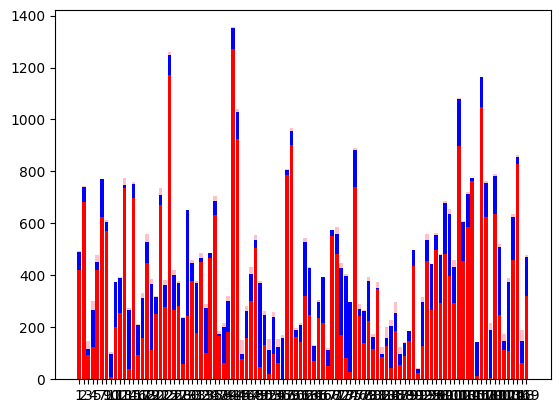

In [ ]:
examplePerformance = Evaluator.evaluateOneGamePerformance(DBSCANPartitionAgent, simplePuzzleData[6])
# simplePuzzleData[0]


Evaluator.plotPerformance(Evaluator.evaluatePerformance(RandomMemoAgent, compliantSimplePuzzleData[:100]))

In [ ]:
color = examplePerformance[0][1]
print([c for c in Color])
print([Color[color.name]])
print(color in [c for c in Color])

[<Color.YELLOW: 1>, <Color.GREEN: 2>, <Color.BLUE: 3>, <Color.PURPLE: 4>]
[<Color.YELLOW: 1>]
False


In [ ]:
colorDict: Dict[Color, str] = {Color.YELLOW: "yellow", Color.GREEN: "green", Color.BLUE: "blue", Color.PURPLE: "purple"}

print(colorDict[color])

KeyError: <Color.YELLOW: 1>

# Test Code / Code Dump

In [ ]:
# Non-deterministic
randomAgentPerformance          = evaluatePerformance(RandomAgent, cleanedData, T = 1)
randomMemoAgentPerformance      = evaluatePerformance(RandomMemoAgent, cleanedData, T = 1)

# Deterministic
smartRandomAgentPerformance     = evaluatePerformance(SmartRandomAgent, cleanedData, T = 1)
DBSCANPartitionAgentPerformance = evaluatePerformance(DBSCANPartitionAgent, cleanedData, T = 1)

In [ ]:
word2VecModel.similarity("hot", "blue")
print(word2VecModel.most_similar(positive="hot"))
# Does not handle opposites well, but that should be ok

In [ ]:
# Increment parameter eps until we have a group of at least 4: then, try all the combos here
DBSCANpartition(InteractivePuzzle(cleanedData[0]).getRemainingUnsolvedPuzzle(), eps = 2.5, min_samples = 4)

In [ ]:
# Produce a clustering
def clusterUnsolvedPuzzle(unsolvedPuzzle: UnsolvedPuzzle, numCategories: int):
  # Transform into an array of the word vector
  wordVectors = np.array([word2VecModel[word] for word in unsolvedPuzzle])


  # Perform K-means clustering
  kmeans = KMeans(n_clusters=numCategories, random_state=0, n_init="auto")
  clusterDistances = kmeans.fit_transform(wordVectors)

  # Get the cluster labels (indices ranging from 0 to num_clusters - 1)
  clusterLabels: List[int] = kmeans.labels_

  # Gather the clustered words
  wordClusters = {clusterLabel : set() for clusterLabel in set(clusterLabels)}

  for (i, word) in enumerate(unsolvedPuzzle):
    # print(f"(i, word) = {i, word}")
    wordClusters[clusterLabels[i]].add(word)

  print(clusterDistances)

  return wordClusters

In [ ]:
print(f"RandomAgent over 100 games: mean = {np.mean(randomAgentPerformance)}, stdev = {np.std(randomAgentPerformance)}")
print(f"RandomMemoAgent over 100 games: mean = {np.mean(randomMemoAgentPerformance)}, stdev = {np.std(randomMemoAgentPerformance)}")
print(f"SmartAgnosticAgent over 100 games: mean = {np.mean(smartRandomAgentPerformance)}, stdev = {np.std(smartRandomAgentPerformance)}")
print(f"DBSCANPartitionAgent over 100 games: mean = {np.mean(DBSCANPartitionAgentPerformance)}, stdev = {np.std(DBSCANPartitionAgentPerformance)}")

In [ ]:
# Evaluate the average number of incorrect guesses needed on the given testing set using the given agent
# Prints a list of T items, representing T trials
#   Each entry is the mean number of incorrect guesses over the test data
def evaluatePerformance(puzzleAgentConstructor, testSet: List[SimplePuzzle], T = 1) -> None:
  numIncorrectGuesses = [[ ] for _ in range(0, T)]
  meanIncorrectGuesses = [0 for _ in range(0, T)]

  for t in range(0, T):
    for simplePuzzle in testSet:
      interactivePuzzle = InteractivePuzzle(simplePuzzle)
      puzzleAgent = puzzleAgentConstructor(interactivePuzzle)

      while not interactivePuzzle.isOver():
        guess = puzzleAgent.getNextMove()
        puzzleAgent.incorporateFeedback(guess, interactivePuzzle.submitGuess(guess))

      # print(f"Number of guesses: {interactivePuzzle.numIncorrectGuesses}")
      numIncorrectGuesses[t].append(interactivePuzzle.numIncorrectGuesses)
      meanIncorrectGuesses[t] += interactivePuzzle.numIncorrectGuesses / len(testSet)

  print(f"{str(puzzleAgentConstructor)} meanIncorrectGuesses performance = {meanIncorrectGuesses}")
  return numIncorrectGuesses[0]

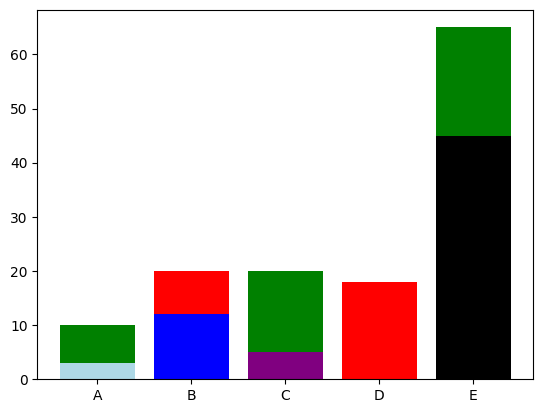

In [ ]:
# Plot bars
# What I want:

# Also, I want average guesses per level (averaged over entire level)
# Ok to do just 1 trial if nondeterministic: averaged over entire data set


import matplotlib.pyplot as plt

y1 = [3, 12, 5, 18, 45]
y2 = [7, 8, 15, 0, 20]
x = ('A', 'B', 'C', 'D', 'E')

df = pd.DataFrame({'y1': y1, 'x': x})


color1 = ['lightblue', 'blue', 'purple', 'red', 'black']
color2 = ['green', 'red', 'green', 'green', 'green']

# Create bars
fig, ax = plt.subplots()
ax.bar(df['x'], df['y1'], color=color1)
plt.bar(x, y2, bottom=y1, color=color2)

# Show graph
plt.show()